IMPORT DEPENDENCIES

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from urllib.request import urlopen, Request

Get the the url

In [4]:
#finviz is a browser-based stock market research platform that makes market information easily accessible to traders and investors.
finviz_url = 'https://finviz.com/quote.ashx?t='
#select some stocks you are interested in
tickers = ['TSLA', 'NVDA', 'AMD']

In [5]:
news_tables = {}
for ticker in tickers:
    #joining the url with tickers to get the particular page
    url = finviz_url + ticker
    #requesting data from the url
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    #creating a beautifulsoup object to get all the data saved in it 
    soup = BeautifulSoup(response, features='html.parser')
    #the id of the news table is passed to get only the data about the news
    news_table = soup.find(id='news-table')
    #saving the content of news table to the object that we created in the start to save the info
    news_tables[ticker] = news_table

parsed_data = []

#iterating over key and value pairs    
for ticker, news_table in news_tables.items():
    
    for row in news_table.findAll('tr'):
        title = row.a.text #title is in the anchor tag
        date_data = row.td.text.split(' ')#split our text based on ' ' as some news have both date and time
        
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
            
        #pass all the values acquired to parsed data
        parsed_data.append([ticker, date, time, title])
    


In [6]:
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

In [7]:
df

,ticker,date,time,title
0,TSLA,Jun-05-22,12:10PM,Dow Jones Futures Due: Market Rally Looks To R...
1,TSLA,Jun-05-22,10:26AM,Dow Jones Futures: Market Rally Looks To Rebou...
2,TSLA,Jun-05-22,10:24AM,Tesla Stock Vs. BYD Stock: Musk 'Super Bad' Wa...
3,TSLA,Jun-05-22,12:30AM,Energy & Precious Metals - Weekly Review and O...
4,TSLA,Jun-04-22,06:54PM,"UPDATE 1-Musk backtracks on job cuts, says Tes..."
...,...,...,...,...
295,AMD,May-17-22,10:33AM,AMD stock climbs after analyst upgrades shares...
296,AMD,May-17-22,09:01AM,AMD Robotics Starter Kit Kick-Starts the Intel...
297,AMD,May-17-22,09:00AM,AMD and Qualcomm Collaborate to Optimize FastC...
298,AMD,May-17-22,03:35AM,"Home Depot, Citigroup, United Airlines Rise Pr..."


In [8]:

vader = SentimentIntensityAnalyzer()

In [9]:
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)   #Taking the title and applying the lamda function to get the compound score of sentiment
df['date'] = pd.to_datetime(df.date).dt.date #Converting the date time from string to date time format

In [10]:
df

,ticker,date,time,title,compound
0,TSLA,2022-06-05,12:10PM,Dow Jones Futures Due: Market Rally Looks To R...,0.0000
1,TSLA,2022-06-05,10:26AM,Dow Jones Futures: Market Rally Looks To Rebou...,0.0000
2,TSLA,2022-06-05,10:24AM,Tesla Stock Vs. BYD Stock: Musk 'Super Bad' Wa...,-0.2500
3,TSLA,2022-06-05,12:30AM,Energy & Precious Metals - Weekly Review and O...,0.7003
4,TSLA,2022-06-04,06:54PM,"UPDATE 1-Musk backtracks on job cuts, says Tes...",-0.2960
...,...,...,...,...,...
295,AMD,2022-05-17,10:33AM,AMD stock climbs after analyst upgrades shares...,0.2960
296,AMD,2022-05-17,09:01AM,AMD Robotics Starter Kit Kick-Starts the Intel...,0.4588
297,AMD,2022-05-17,09:00AM,AMD and Qualcomm Collaborate to Optimize FastC...,0.5994
298,AMD,2022-05-17,03:35AM,"Home Depot, Citigroup, United Airlines Rise Pr...",0.4215


In [12]:
df.to_csv('Sentiment of Stocks.csv')

<Figure size 720x576 with 0 Axes>

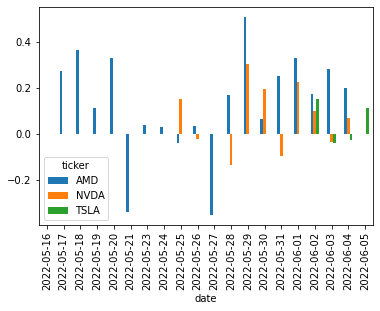

In [11]:
#visualising if the day has been positive or negative for the stock
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
mean_df = mean_df.xs('compound', axis="columns").transpose()
mean_df.plot(kind='bar')
plt.show()